# Clustering To Explore Neighbourhoods (Part IV - Continued Because Spark Hates Me)
## Review
I ran into a major dead end in the last post. The problem? Data pre-processing... You don't often think that data processing would be the activity that prevents you from moving forward eh? As a novice data scientist, you're so infatuated with the high level objective, the meat of the analysis, the sexy chart or graph or insight that you're trying to find... Luckily I've had enough experience cleaning data in my previous jobs to know how important of a step it really is, and this is a great example of that. This dead end is literally making me pivot and change directions...

The last post, however, wasn't a complete wash despite the tragic ending. It allowed me to go deeper into Spark's memory mangement. I took a _**very**_ close look at the memory usage of each node (1 master + 2 workers) as my notebook ran, and I was able to understand a bit better the intricacies of the master memory usage vs worker memory usage. The fact that I was even able to get to the one hot encoding step was a product of this memory monitoring. I'm sure this will help us going forward with my new method as well.

This project just seems to be sprawling in different directions and losing scope with every notebook, but I guess this is what data science looks like haha.

<img src="https://i.imgur.com/RFSgkaw.gif" width="400">

Let's get our dataframe back to the way it was before one hot encoding, and try another method.

In [1]:
import os
os.system("sudo pip install findspark sql_magic pyspark_dist_explore seaborn")

0

In [2]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Load Data

In [3]:
%%time
# Read NYPD Complaint Data
df_filtered = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet")
df_filtered.cache()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.27 s


## K-Means

In [4]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Set seed for ability to reproduce results, 20 clusters
kmeans = KMeans(k = 20, seed = 1)

# Initiate and transform columns into vector
vecAssembler = VectorAssembler(inputCols = ['LAT', 'LON'], outputCol = "features")
k_means_input = vecAssembler.transform(df_filtered)

In [5]:
%%time
# Refit model
model = kmeans.fit(k_means_input[['features']])

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 2min 25s


In [6]:
%%time
# Use model to assign the samples a cluster to belong to
prediction = model.transform(k_means_input[['features']])
print(prediction.head(5))

[Row(features=DenseVector([40.8288, -73.9167]), prediction=0), Row(features=DenseVector([40.6973, -73.7846]), prediction=10), Row(features=DenseVector([40.8026, -73.9451]), prediction=19), Row(features=DenseVector([40.6545, -73.7263]), prediction=10), Row(features=DenseVector([40.738, -73.9879]), prediction=6)]
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 440 ms


### Join K-Means Clusters Into Original Dataframe

In [7]:
# Since there are no common column between these two dataframes add row_index so that it can be joined
df_filtered_indexed = df_filtered.withColumn('row_index', F.monotonically_increasing_id())
df_filtered.unpersist()

prediction_indexed = prediction.withColumn('row_index', F.monotonically_increasing_id())
prediction.unpersist()

DataFrame[features: vector, prediction: int]

In [8]:
# Perform join on our generated ID row_index
df_predicted = df_filtered_indexed.join(prediction_indexed, on = ['row_index'], how = 'left').drop('row_index')
df_filtered_indexed.unpersist()
prediction_indexed.unpersist()

DataFrame[features: vector, prediction: int, row_index: bigint]

### Viewing Clusters

In [9]:
# Add table to SQL Context
df_predicted.createOrReplaceTempView("df_predicted")

In [10]:
cluster_stats_result = %read_sql \
SELECT \
    prediction, \
    COUNT(*) AS NUM_SAMPLES, \
    AVG(LAT) AS LAT_CENTRE, \
    AVG(LON) AS LON_CENTRE \
FROM df_predicted \
GROUP BY \
    prediction

Query started at 04:22:24 AM UTC; Query executed in 0.38 m

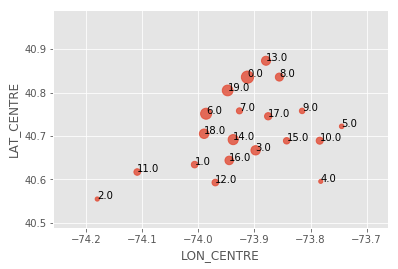

In [11]:
# See cluster centres
fig, ax = plt.subplots()
sns.regplot(
    x = "LON_CENTRE", 
    y = "LAT_CENTRE", 
    data = cluster_stats_result, 
    fit_reg = False, 
    scatter_kws = {'s': cluster_stats_result['NUM_SAMPLES'] / cluster_stats_result['NUM_SAMPLES'].max() * 150},
    ax = ax
)
cluster_stats_result[['LON_CENTRE','LAT_CENTRE','prediction']].apply(lambda x: ax.text(*x), axis=1);

## Alternate Cluster Summary Processing
Alright. Let's review our task again. Remember, we're trying to get a dataframe that looks like this:

In [12]:
pd.DataFrame({
    'COMPLAINT_NUMBER': [1, 2, 3, 4, 5],
    'CLUSTER': [1, 1, 2, 2, 2],
    'OFFENSE_LEVEL': ['VIOLATION', 'VIOLATION', 'MISDEMEANOR', 'FELONY', 'FELONY']
})

,CLUSTER,COMPLAINT_NUMBER,OFFENSE_LEVEL
0,1,1,VIOLATION
1,1,2,VIOLATION
2,2,3,MISDEMEANOR
3,2,4,FELONY
4,2,5,FELONY


Into a dataframe like this:

In [13]:
pd.DataFrame({
    'COMPLAINT_NUMBER': [1, 2, 3, 4, 5],
    'CLUSTER': [1, 1, 2, 2, 2],
    'OFFENSE_LEVEL_VIOLATION': [1, 1, 0, 0, 0],
    'OFFENSE_LEVEL_MISDEMEANOR': [0, 0, 1, 0, 0],
    'OFFENSE_LEVEL_FELONY': [0, 0, 0, 1, 1]
})

,CLUSTER,COMPLAINT_NUMBER,OFFENSE_LEVEL_FELONY,OFFENSE_LEVEL_MISDEMEANOR,OFFENSE_LEVEL_VIOLATION
0,1,1,0,0,1
1,1,2,0,0,1
2,2,3,0,1,0
3,2,4,1,0,0
4,2,5,1,0,0


Would have loved to resort to a cleaner option, but the only thing I can think of right now is to hardcode the mappings between the values and the encoded volumns within SQL itself. It's going to be messy, but at least I'm confident it will work (well, I guess I shouldn't speak so soon...).

In [14]:
%read_sql SELECT \
    OFFENSE_LEVEL, \
    CASE \
        WHEN (OFFENSE_LEVEL = 'MISDEMEANOR') THEN 1 \
        ELSE 0 \
    END AS OFFENSE_LEVEL_MISDEMEANOR, \
    CASE \
        WHEN (OFFENSE_LEVEL = 'VIOLATION') THEN 1 \
        ELSE 0 \
    END AS OFFENSE_LEVEL_VIOLATION, \
    CASE \
        WHEN (OFFENSE_LEVEL = 'FELONY') THEN 1 \
        ELSE 0 \
    END AS OFFENSE_LEVEL_FELONY \
FROM df_predicted \
LIMIT 10

Query started at 04:22:47 AM UTC; Query executed in 0.19 m

,OFFENSE_LEVEL,OFFENSE_LEVEL_MISDEMEANOR,OFFENSE_LEVEL_VIOLATION,OFFENSE_LEVEL_FELONY
0,FELONY,0,0,1
1,FELONY,0,0,1
2,FELONY,0,0,1
3,MISDEMEANOR,1,0,0
4,MISDEMEANOR,1,0,0
5,FELONY,0,0,1
6,MISDEMEANOR,1,0,0
7,FELONY,0,0,1
8,MISDEMEANOR,1,0,0
9,MISDEMEANOR,1,0,0


That works. The code is going to look _**absolutely horrible**_ when I add in OFFENSE\_DESCRIPTION and PREMISE\_DESCRIPTION as well. Hooray.

In [21]:
# Perform manual one hot encoding to dense columns through SQL
df_encoded = spark.sql(" \
    SELECT \
        prediction as CLUSTER, \
        LAT, \
        LON, \
        OFFENSE_DESCRIPTION, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'PETIT LARCENY') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_PETIT_LARCENY, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'HARRASSMENT 2') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_HARRASSMENT, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'ASSAULT 3 & RELATED OFFENSES') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_ASSAULT_3, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'CRIMINAL MISCHIEF & RELATED OF') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_MISCHIEF, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'GRAND LARCENY') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_GRAND_LARCENY, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'DANGEROUS DRUGS') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_DANGEROUS_DRUGS, \
        CASE \
            WHEN (OFFENSE_DESCRIPTION = 'FELONY ASSAULT') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_DESCRIPTION_FELONY_ASSAULT, \
        OFFENSE_LEVEL, \
        CASE \
            WHEN (OFFENSE_LEVEL = 'MISDEMEANOR') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_LEVEL_MISDEMEANOR, \
        CASE \
            WHEN (OFFENSE_LEVEL = 'VIOLATION') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_LEVEL_VIOLATION, \
        CASE \
            WHEN (OFFENSE_LEVEL = 'FELONY') THEN 1 \
            ELSE 0 \
        END AS OFFENSE_LEVEL_FELONY, \
        PREMISE_DESCRIPTION, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'RESIDENCE - APT. HOUSE') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_RESIDENCE_APARTMENT, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'RESIDENCE - PUBLIC HOUSING') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'TRANSIT - NYC SUBWAY') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_SUBWAY, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'STREET') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_STREET, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'COMMERCIAL BUILDING') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_COMMERCIAL_BUILDING, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'PUBLIC SCHOOL') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_PUBLIC_SCHOOL, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'RESIDENCE-HOUSE') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_RESIDENCE_HOUSE, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'RESTAURANT/DINER') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_RESTAURANT_DINER, \
        CASE \
            WHEN (PREMISE_DESCRIPTION = 'BAR/NIGHT CLUB') THEN 1 \
            ELSE 0 \
        END AS PREMISE_DESCRIPTION_BAR_NIGHT_CLUB \
    FROM df_predicted \
")

In [22]:
# Add table to SQL Context
df_encoded.createOrReplaceTempView("df_encoded")

Now we can actually summarize all the metrics per cluster by adding up all the instances of each columns. E.g., we'd be looking for the amount of Dangerous Drugs, Grand Larcenies, and Harrassments per cluster. It might be useful to then take some summary statistics after the fact, but let's do the grouping first.

In [23]:
%read_sql DESCRIBE df_encoded

Query started at 04:45:12 AM UTC; Query executed in 0.00 m

,col_name,data_type,comment
0,CLUSTER,int,None
1,LAT,double,None
2,LON,double,None
3,OFFENSE_DESCRIPTION,string,None
4,OFFENSE_DESCRIPTION_PETIT_LARCENY,int,None
5,OFFENSE_DESCRIPTION_HARRASSMENT,int,None
6,OFFENSE_DESCRIPTION_ASSAULT_3,int,None
7,OFFENSE_DESCRIPTION_MISCHIEF,int,None
8,OFFENSE_DESCRIPTION_GRAND_LARCENY,int,None
9,OFFENSE_DESCRIPTION_DANGEROUS_DRUGS,int,None


In [24]:
cluster_summary = %read_sql \
SELECT \
    CLUSTER, \
    COUNT(*) AS NUM_CRIMES, \
    AVG(LAT) AS LAT_CENTRE, \
    AVG(LON) AS LON_CENTRE, \
    SUM(OFFENSE_DESCRIPTION_PETIT_LARCENY) AS OFFENSE_DESCRIPTION_PETIT_LARCENY, \
    SUM(OFFENSE_DESCRIPTION_HARRASSMENT) AS OFFENSE_DESCRIPTION_HARRASSMENT, \
    SUM(OFFENSE_DESCRIPTION_ASSAULT_3) AS OFFENSE_DESCRIPTION_ASSAULT_3, \
    SUM(OFFENSE_DESCRIPTION_MISCHIEF) AS OFFENSE_DESCRIPTION_MISCHIEF, \
    SUM(OFFENSE_DESCRIPTION_DANGEROUS_DRUGS) AS OFFENSE_DESCRIPTION_DANGEROUS_DRUGS, \
    SUM(OFFENSE_DESCRIPTION_FELONY_ASSAULT) AS OFFENSE_DESCRIPTION_FELONY_ASSAULT, \
    SUM(OFFENSE_LEVEL_MISDEMEANOR) AS OFFENSE_LEVEL_MISDEMEANOR, \
    SUM(OFFENSE_LEVEL_VIOLATION) AS OFFENSE_LEVEL_VIOLATION, \
    SUM(OFFENSE_LEVEL_FELONY) AS OFFENSE_LEVEL_FELONY, \
    SUM(PREMISE_DESCRIPTION_RESIDENCE_APARTMENT) AS PREMISE_DESCRIPTION_RESIDENCE_APARTMENT, \
    SUM(PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING) AS PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING, \
    SUM(PREMISE_DESCRIPTION_SUBWAY) AS PREMISE_DESCRIPTION_SUBWAY, \
    SUM(PREMISE_DESCRIPTION_STREET) AS PREMISE_DESCRIPTION_STREET, \
    SUM(PREMISE_DESCRIPTION_COMMERCIAL_BUILDING) AS PREMISE_DESCRIPTION_COMMERCIAL_BUILDING, \
    SUM(PREMISE_DESCRIPTION_PUBLIC_SCHOOL) AS PREMISE_DESCRIPTION_PUBLIC_SCHOOL, \
    SUM(PREMISE_DESCRIPTION_RESIDENCE_HOUSE) AS PREMISE_DESCRIPTION_RESIDENCE_HOUSE, \
    SUM(PREMISE_DESCRIPTION_RESTAURANT_DINER) AS PREMISE_DESCRIPTION_RESTAURANT_DINER, \
    SUM(PREMISE_DESCRIPTION_BAR_NIGHT_CLUB) AS PREMISE_DESCRIPTION_BAR_NIGHT_CLUB \
FROM df_encoded \
GROUP BY \
    CLUSTER

Query started at 04:50:27 AM UTC; Query executed in 0.73 m

In [27]:
# View results
cluster_summary

,CLUSTER,NUM_CRIMES,LAT_CENTRE,LON_CENTRE,OFFENSE_DESCRIPTION_PETIT_LARCENY,OFFENSE_DESCRIPTION_HARRASSMENT,OFFENSE_DESCRIPTION_ASSAULT_3,OFFENSE_DESCRIPTION_MISCHIEF,OFFENSE_DESCRIPTION_DANGEROUS_DRUGS,OFFENSE_DESCRIPTION_FELONY_ASSAULT,...,OFFENSE_LEVEL_FELONY,PREMISE_DESCRIPTION_RESIDENCE_APARTMENT,PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING,PREMISE_DESCRIPTION_SUBWAY,PREMISE_DESCRIPTION_STREET,PREMISE_DESCRIPTION_COMMERCIAL_BUILDING,PREMISE_DESCRIPTION_PUBLIC_SCHOOL,PREMISE_DESCRIPTION_RESIDENCE_HOUSE,PREMISE_DESCRIPTION_RESTAURANT_DINER,PREMISE_DESCRIPTION_BAR_NIGHT_CLUB
0,12,183862,40.592803,-73.969842,31425,23652,18246,21816,8878,5858,...,58228,35787,17031,2657,60503,2850,2941,24498,1355,974
1,1,179745,40.634055,-74.006811,31264,24012,17975,22601,7050,5817,...,54697,40004,24,2335,73211,4491,1924,21388,1835,1693
2,13,340058,40.873135,-73.879422,44995,41210,39286,35203,34636,15504,...,97845,94490,16764,4562,132004,3882,5044,24844,1848,1188
3,6,504025,40.751261,-73.986319,144494,42817,34024,27482,19018,9674,...,181763,64500,8081,23188,130883,40552,4486,2633,20270,23645
4,16,304220,40.643766,-73.945032,46132,38306,34849,30413,15752,13520,...,102234,80934,2146,2532,113464,4457,3330,42006,2064,1367
5,3,363679,40.667012,-73.897975,39278,45391,47810,36411,35872,18594,...,116011,76484,46986,6425,124636,4247,4338,45934,1359,533
6,5,87249,40.722177,-73.744405,11299,11890,8523,11673,1032,2966,...,33232,8882,100,1,28357,1365,1501,32501,560,223
7,19,477917,40.804788,-73.947876,70849,59316,48222,42459,50061,17379,...,129901,109286,89216,16472,146018,6453,5992,3712,4936,2631
8,15,174254,40.688913,-73.842615,26406,23293,18613,23029,4603,6287,...,58580,28546,2239,2636,66049,4139,1444,37158,1400,1638
9,17,220482,40.745377,-73.875549,40665,23723,23799,22368,6720,9741,...,72087,44627,198,2336,78128,4182,1363,29610,2398,3200


Awesome! We now have all our cluster metrics in a _**pandas**_ dataframe. Note that we are now working in _**PYTHON**_ and not _**PYSPARK**_ anymore. Our dataframe is 20 x 22, so we have more then enough memory on our master node to just work in master memory! The first thing I want to do is to convert each of my metrics columns into z-score.

In [62]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

# Define columns to take z-score of
zscore_cols = [
    'OFFENSE_DESCRIPTION_PETIT_LARCENY',
    'OFFENSE_DESCRIPTION_HARRASSMENT',
    'OFFENSE_DESCRIPTION_ASSAULT_3',
    'OFFENSE_DESCRIPTION_MISCHIEF',
    'OFFENSE_DESCRIPTION_DANGEROUS_DRUGS',
    'OFFENSE_DESCRIPTION_FELONY_ASSAULT',
    'OFFENSE_LEVEL_MISDEMEANOR',
    'OFFENSE_LEVEL_VIOLATION',
    'OFFENSE_LEVEL_FELONY',
    'PREMISE_DESCRIPTION_RESIDENCE_APARTMENT',
    'PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING',
    'PREMISE_DESCRIPTION_SUBWAY',
    'PREMISE_DESCRIPTION_STREET',
    'PREMISE_DESCRIPTION_COMMERCIAL_BUILDING',
    'PREMISE_DESCRIPTION_PUBLIC_SCHOOL',
    'PREMISE_DESCRIPTION_RESIDENCE_HOUSE',
    'PREMISE_DESCRIPTION_RESTAURANT_DINER',
    'PREMISE_DESCRIPTION_BAR_NIGHT_CLUB'
]

# Initialize scaler
scaler = StandardScaler()

# Replace initial columns with z-score columns
cluster_summary_standard = cluster_summary.drop(zscore_cols, axis = 1).merge(
    pd.DataFrame(scaler.fit_transform(cluster_summary[zscore_cols]), columns = zscore_cols), 
    left_index = True, 
    right_index = True
)

# View results
cluster_summary_standard.head()

,CLUSTER,NUM_CRIMES,LAT_CENTRE,LON_CENTRE,OFFENSE_DESCRIPTION_PETIT_LARCENY,OFFENSE_DESCRIPTION_HARRASSMENT,OFFENSE_DESCRIPTION_ASSAULT_3,OFFENSE_DESCRIPTION_MISCHIEF,OFFENSE_DESCRIPTION_DANGEROUS_DRUGS,OFFENSE_DESCRIPTION_FELONY_ASSAULT,...,OFFENSE_LEVEL_FELONY,PREMISE_DESCRIPTION_RESIDENCE_APARTMENT,PREMISE_DESCRIPTION_RESIDENCE_PUBLIC_HOUSING,PREMISE_DESCRIPTION_SUBWAY,PREMISE_DESCRIPTION_STREET,PREMISE_DESCRIPTION_COMMERCIAL_BUILDING,PREMISE_DESCRIPTION_PUBLIC_SCHOOL,PREMISE_DESCRIPTION_RESIDENCE_HOUSE,PREMISE_DESCRIPTION_RESTAURANT_DINER,PREMISE_DESCRIPTION_BAR_NIGHT_CLUB
0,12,183862,40.592803,-73.969842,-0.402207,-0.572521,-0.570313,-0.437944,-0.470620,-0.615744,...,-0.511930,-0.447990,-0.134995,-0.420059,-0.544142,-0.472868,-0.224976,-0.115843,-0.395071,-0.399264
1,1,179745,40.634055,-74.006811,-0.407374,-0.550305,-0.585838,-0.372603,-0.563246,-0.621778,...,-0.588419,-0.351381,-0.824596,-0.472647,-0.300606,-0.284282,-0.723560,-0.315950,-0.283969,-0.260616
2,13,340058,40.873135,-73.879422,0.033286,0.511025,0.635092,0.676352,0.834557,0.803789,...,0.346262,0.896860,-0.145821,-0.108941,0.826104,-0.354269,0.806020,-0.093581,-0.280960,-0.357998
3,6,504025,40.751261,-73.986319,3.226442,0.610197,0.333626,0.033678,0.043182,-0.054171,...,2.164110,0.209808,-0.497900,2.933000,0.804621,3.859910,0.532460,-1.522704,3.983035,3.972491
4,16,304220,40.643766,-73.945032,0.069775,0.331812,0.380891,0.277646,-0.122309,0.511818,...,0.441337,0.586300,-0.738553,-0.440474,0.470803,-0.288189,-0.034268,1.010675,-0.230964,-0.323480


## PCA
Perfect! Perhaps the best way to explore the correlations amongst all these is to take the PCA and see if certain correlations can be found within the clusters.

In [63]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit data
cluster_summary_pca = pca.fit_transform(cluster_summary[zscore_cols])

# Look at the variance explained by the components
print(pca.explained_variance_ratio_)

[ 0.90654445  0.05546962]


We see that 91% of the variance is explained through _**the first axis**_! This means there should be high correlations amongst the metrics across all the clusters (neighbourhoods), or in other words, the crimes in new york can be highly explained by the neighbourhood they occur in.

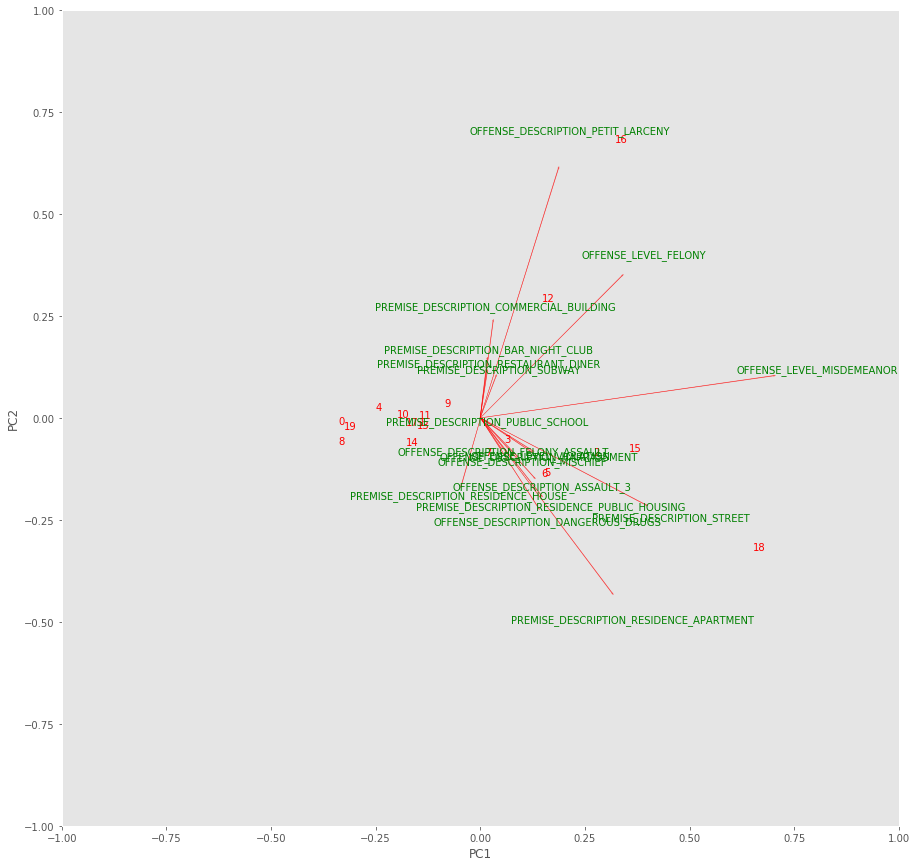

In [84]:
# Define function to view biplot
def myplot(score, coeff, line_labels, scatter_labels):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
#     plt.scatter(xs * scalex, ys * scaley)
    for i in range(len(score[:,0])):
        plt.text(xs[i-1] * scalex, ys[i-1] * scaley, scatter_labels[i], color = 'r', ha = 'center', va = 'center')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, line_labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(15,15))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

# View biplot
myplot(cluster_summary_pca[:,0:2],np.transpose(pca.components_[0:2, :]), zscore_cols, cluster_summary['CLUSTER'].tolist())

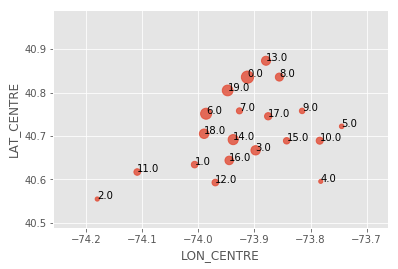

In [82]:
# See cluster centres
fig, ax = plt.subplots()
sns.regplot(
    x = "LON_CENTRE", 
    y = "LAT_CENTRE", 
    data = cluster_stats_result, 
    fit_reg = False, 
    scatter_kws = {'s': cluster_stats_result['NUM_SAMPLES'] / cluster_stats_result['NUM_SAMPLES'].max() * 150},
    ax = ax
)
cluster_stats_result[['LON_CENTRE','LAT_CENTRE','prediction']].apply(lambda x: ax.text(*x), axis=1);